In [293]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

download dataset

In [294]:
train_data = pd.read_csv(r"D:\coding\jupyter_notebook\data\kaggle_house_price_prediction\train.csv")
test_data = pd.read_csv(r"D:\coding\jupyter_notebook\data\kaggle_house_price_prediction\test.csv")

In [295]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


数据预处理

In [296]:
#第一列没啥用（就是索引），所以去掉第一列组成all_features这一个dataframe
all_features = pd.concat((train_data.iloc[:, 1:], test_data.iloc[:, 1:]))

In [297]:
all_features.shape

(2919, 80)

In [298]:
all_features.index

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458],
      dtype='int64', length=2919)

先处理数值类型的列数据

In [299]:
all_features.dtypes[all_features.dtypes != 'object']

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
dtype: object

In [300]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

In [301]:
len(numeric_features)

37

In [302]:
#标准化数据
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))

In [303]:
all_features[numeric_features] = all_features[numeric_features].fillna(0)

再处理离散类别值

In [304]:
# use one-hot
all_features = pd.get_dummies(all_features, dummy_na = True, dtype = np.uint8)

In [305]:
all_features.shape

(2919, 331)

转化为tensor

In [306]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype = torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype = torch.float32)

开始训练！

In [307]:
loss = nn.MSELoss()
in_features = train_features.shape[1]
dropout1 = 0.2
dropout2 = 0.6
def get_net():   # one linear layer
    net = nn.Sequential(nn.Linear(in_features, 64),
                       nn.ReLU(),
                       nn.Dropout(dropout1),
                       
                       nn.Linear(64, 1))
    return net

In [308]:
in_features

331

In [309]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [310]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls  # 返回最后一个epoch的损失

K折交叉验证

In [311]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)  #切片对象
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train == None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], dim=0)
            y_train = torch.cat([y_train, y_part], dim=0)
    return X_train, y_train, X_valid, y_valid
# train是训练集,valid是验证集，返回两集

In [312]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], xlabel='epoch', ylabel='rmse', 
                     xlim=[1,num_epochs], legend=['train','valid'], yscale='log')   # 只画了第一折的loss随epoch变化的图像
        print(f'折{i+1}, 训练log rmse{float(train_ls[-1]):f}, '
             f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1, 训练log rmse0.183115, 验证log rmse0.177482
折2, 训练log rmse0.171029, 验证log rmse0.191418
折3, 训练log rmse0.167306, 验证log rmse0.189507
3-折验证：平均训练log rmse:0.173817, 平均验证log rmse:0.186136


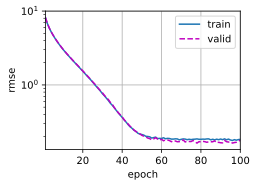

In [313]:
k, num_epochs, lr, weight_decay, batch_size = 3, 100, 0.01, 50, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse:{float(train_l):f}, '
     f'平均验证log rmse:{float(valid_l):f}')

提交kaggle预测

In [314]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel = 'epoch', ylabel = 'log rmse', xlim=[1, num_epochs], yscale = 'log')
    print(f'训练log rmse:{float(train_ls[-1]):f}')
    
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis = 1)
    submission.to_csv('submission.csv', index = False)

训练log rmse:0.152320


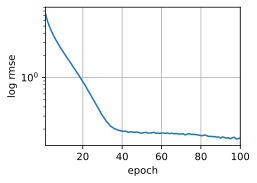

In [315]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)